# Axona to NWB

Convert Axona raw (`.bin` + `.set`) or unit data (`.X`, `.pos`, `.eeg`, `.egf`) to NWB format. 

It might be handy to convert the position data in the `.bin` file to a `.pos` file, allowing us to use the same code for both axona formats, as well as the Intan format later on (requiring the Hussaini lab to create their own `.pos` files based on the position tracking used). 

### Axona raw (`.bin` + `.set`)

In [111]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
import os
from pathlib import Path

# Old .bin file
base_dir = Path('/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/')
dir_name = base_dir / 'example_data_raw'
base_filename = '20201004_Raw'

# New .bin file
base_dir = Path('/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/new_session_data')
dir_name = base_dir / '06172021-HPC-B6-RAW'
base_filename = '06172021-HPC-B6-RAW'
filename = os.path.join(dir_name, base_filename)
set_file = filename + '.set'
bin_file = filename + '.bin'
print(filename)

/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/new_session_data/06172021-HPC-B6-RAW/06172021-HPC-B6-RAW


In [116]:
from nwb_conversion_tools import (
    NWBConverter, AxonaRecordingExtractorInterface, AxonaPositionDataInterface
)

In [117]:
class HussainiAxonaNWBConverter(NWBConverter):
    data_interface_classes = dict(
        AxonaRecordingExtractorInterface=AxonaRecordingExtractorInterface,
        AxonaPositionDataInterface=AxonaPositionDataInterface
    )

In [118]:
import random
import string
from typing import Union, Optional
from pathlib import Path
import spikeextractors as se
from pynwb import NWBFile
import numpy as np
import re
import datetime
import json
from jsonschema import validate, ValidationError

from nwb_conversion_tools.utils.json_schema import get_schema_from_method_signature, get_base_schema, fill_defaults
from nwb_conversion_tools import SpikeGLXRecordingInterface

In [119]:
# Specify source data

source_data = dict(
    AxonaPositionDataInterface=dict(
        filename=set_file
    ),
    AxonaRecordingExtractorInterface=dict(
        filename=set_file
    )
)
print(json.dumps(source_data, indent=2))

{
  "AxonaPositionDataInterface": {
    "filename": "/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/new_session_data/06172021-HPC-B6-RAW/06172021-HPC-B6-RAW.set"
  },
  "AxonaRecordingExtractorInterface": {
    "filename": "/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/new_session_data/06172021-HPC-B6-RAW/06172021-HPC-B6-RAW.set"
  }
}


In [120]:
# Initialize HussainiAxonaNWBConverter

converter = HussainiAxonaNWBConverter(source_data=source_data)

Source data is valid!


In [121]:
# Get metadata

metadata = converter.get_metadata()
metadata

{'NWBFile': {'session_description': '',
  'session_start_time': '2021-06-17T12:22:02',
  'identifier': '8ed6f711-1eae-4dec-8ed4-6a8140c99d11',
  'experimenter': ['Abid']},
 'Ecephys': {'Device': [{'name': 'Axona',
    'description': 'Axona DacqUSB, sw_version=1.2.2.16',
    'manufacturer': 'Axona'}],
  'ElectrodeGroup': [{'name': 'Group0',
    'location': '',
    'device': 'Axona',
    'description': 'Group 0 electrodes.'},
   {'name': 'Group1',
    'location': '',
    'device': 'Axona',
    'description': 'Group 1 electrodes.'},
   {'name': 'Group2',
    'location': '',
    'device': 'Axona',
    'description': 'Group 2 electrodes.'},
   {'name': 'Group3',
    'location': '',
    'device': 'Axona',
    'description': 'Group 3 electrodes.'}],
  'Electrodes': [{'name': 'group_name',
    'description': 'The name of the ElectrodeGroup this electrode is a part of.'}],
  'ElectricalSeries_raw': {'name': 'ElectricalSeries_raw',
   'description': 'Raw acquisition traces.'}}}

In [122]:
# Get metadata_schema from converter

metadata_schema = converter.get_metadata_schema()

print(json.dumps(metadata_schema['properties'], indent=2))

{
  "NWBFile": {
    "required": [
      "session_description",
      "identifier",
      "session_start_time"
    ],
    "properties": {
      "session_description": {
        "type": "string",
        "format": "long",
        "description": "a description of the session where this data was generated",
        "default": ""
      },
      "identifier": {
        "type": "string",
        "description": "a unique text identifier for the file",
        "default": "7937447f-057f-4688-9a93-cb77b84d0425"
      },
      "session_start_time": {
        "type": "string",
        "description": "the start date and time of the recording session",
        "format": "date-time",
        "default": "2021-06-17T12:22:02"
      },
      "experimenter": {
        "type": "array",
        "items": {
          "type": "string",
          "title": "experimenter"
        },
        "description": "name of person who performed experiment",
        "default": [
          "Abid"
        ]
      },
      "e

In [123]:
# Validate metadata against metadata_schema

validate(
    instance=converter.get_metadata(),
    schema=converter.get_metadata_schema()
)

In [124]:
converter.get_metadata()

{'NWBFile': {'session_description': '',
  'session_start_time': '2021-06-17T12:22:02',
  'identifier': '7bda794d-9e11-4559-b554-3b3969fa6e99',
  'experimenter': ['Abid']},
 'Ecephys': {'Device': [{'name': 'Axona',
    'description': 'Axona DacqUSB, sw_version=1.2.2.16',
    'manufacturer': 'Axona'}],
  'ElectrodeGroup': [{'name': 'Group0',
    'location': '',
    'device': 'Axona',
    'description': 'Group 0 electrodes.'},
   {'name': 'Group1',
    'location': '',
    'device': 'Axona',
    'description': 'Group 1 electrodes.'},
   {'name': 'Group2',
    'location': '',
    'device': 'Axona',
    'description': 'Group 2 electrodes.'},
   {'name': 'Group3',
    'location': '',
    'device': 'Axona',
    'description': 'Group 3 electrodes.'}],
  'Electrodes': [{'name': 'group_name',
    'description': 'The name of the ElectrodeGroup this electrode is a part of.'}],
  'ElectricalSeries_raw': {'name': 'ElectricalSeries_raw',
   'description': 'Raw acquisition traces.'}}}

In [125]:
from nwb_conversion_tools.utils.conversion_tools import (
    get_default_nwbfile_metadata, make_nwbfile_from_metadata
)

In [126]:
metadata

{'NWBFile': {'session_description': '',
  'session_start_time': '2021-06-17T12:22:02',
  'identifier': '8ed6f711-1eae-4dec-8ed4-6a8140c99d11',
  'experimenter': ['Abid']},
 'Ecephys': {'Device': [{'name': 'Axona',
    'description': 'Axona DacqUSB, sw_version=1.2.2.16',
    'manufacturer': 'Axona'}],
  'ElectrodeGroup': [{'name': 'Group0',
    'location': '',
    'device': 'Axona',
    'description': 'Group 0 electrodes.'},
   {'name': 'Group1',
    'location': '',
    'device': 'Axona',
    'description': 'Group 1 electrodes.'},
   {'name': 'Group2',
    'location': '',
    'device': 'Axona',
    'description': 'Group 2 electrodes.'},
   {'name': 'Group3',
    'location': '',
    'device': 'Axona',
    'description': 'Group 3 electrodes.'}],
  'Electrodes': [{'name': 'group_name',
    'description': 'The name of the ElectrodeGroup this electrode is a part of.'}],
  'ElectricalSeries_raw': {'name': 'ElectricalSeries_raw',
   'description': 'Raw acquisition traces.'}}}

In [127]:
output_file = base_dir / 'out_example.nwb'

In [76]:
# Export to NWB file

output_file = base_dir / 'out_example.nwb'

converter.run_conversion(
    metadata=metadata, 
    nwbfile_path=output_file,
    overwrite=True,
    save_to_file=True,
    conversion_options=None
)

Metadata is valid!


/home/sbuergers/spikeinterface/hussaini-test-pipeline/venv/lib/python3.8/site-packages/pynwb/file.py:801: UserWarning: Date is missing timezone information. Updating to local timezone.
  warn("Date is missing timezone information. Updating to local timezone.")
/home/sbuergers/spikeinterface/hussaini-test-pipeline/venv/lib/python3.8/site-packages/hdmf/common/table.py:447: UserWarning: An attribute 'name' already exists on DynamicTable 'electrodes' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  warn(msg)


NWB file saved at /mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/out_example.nwb!


In [10]:
# Check NWB file

from pynwb import NWBHDF5IO

fname = output_file
with NWBHDF5IO(fname, 'r') as io:
    nwbfile = io.read()
    print(nwbfile)

root pynwb.file.NWBFile at 0x139787164895408
Fields:
  file_create_date: [datetime.datetime(2021, 5, 26, 14, 44, 7, 643734, tzinfo=tzoffset(None, -14400))]
  identifier: 606b96b1-69e4-45f5-850e-b25863a0d6a7
  session_description: Auto-generated by NwbRecordingExtractor without description.
  session_start_time: 1970-01-01 00:00:00-05:00
  timestamps_reference_time: 1970-01-01 00:00:00-05:00
  units: units <class 'pynwb.misc.Units'>



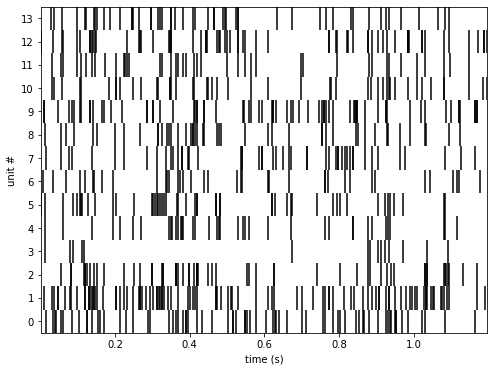

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt


from nwbwidgets import nwb2widget

output_file = '/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint/nwb/axona_se_MS4.nwb'
#output_file = '/mnt/d/NWB/data/NWBData/NWBData/P9HMH_NOID5.nwb'

io = NWBHDF5IO(output_file, mode='r')
nwb = io.read()

nwb2widget(nwb)

In [46]:
from nwb_conversion_tools.datainterfaces.ecephys.axona.axonadatainterface import get_position_object

pos = get_position_object(filename=set_file)

In [47]:
nwb.processing['behavior'].data_interfaces['Position'].spatial_series['t'].data

<HDF5 dataset "data": shape (59965,), type "<f8">

In [51]:
pos.spatial_series['t'].timestamps

array([6.25000000e-02, 8.75000000e-01, 6.37500000e+00, ...,
       5.99976375e+05, 5.99986375e+05, 5.99996375e+05])

### Parse `.pos` files

Header

In [12]:
import mmap
import contextlib

In [128]:
from nwb_conversion_tools.datainterfaces.ecephys.axona.axonadatainterface import parse_generic_header

# Old pos file
pos_file = '/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint/axona_sample.pos'

# New pos file
pos_file = '/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/new_session_data/06172021-HPC-B6-UNIT/06172021-HPC-B6-UNIT/06172021-B6-HPC-UNIT.pos'
print(pos_file)

pos_header = parse_generic_header(pos_file, None)
pos_header

/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/new_session_data/06172021-HPC-B6-UNIT/06172021-HPC-B6-UNIT/06172021-B6-HPC-UNIT.pos


{'trial_date': 'Thursday, 17 Jun 2021',
 'trial_time': '12:22:02',
 'experimenter': 'Abid',
 'comments': '',
 'duration': '301',
 'sw_version': '1.2.2.16',
 'num_colours': '4',
 'min_x': '0',
 'max_x': '640',
 'min_y': '0',
 'max_y': '480',
 'window_min_x': '247',
 'window_max_x': '426',
 'window_min_y': '179',
 'window_max_y': '357',
 'timebase': '50 hz',
 'bytes_per_timestamp': '4',
 'sample_rate': '50.0 hz',
 'EEG_samples_per_position': '5',
 'bearing_colour_1': '0',
 'bearing_colour_2': '0',
 'bearing_colour_3': '0',
 'bearing_colour_4': '0',
 'pos_format': 't,x1,y1,x2,y2,numpix1,numpix2',
 'bytes_per_coord': '2',
 'pixels_per_metre': '300',
 'num_pos_samples': '15050'}

Data (with memory map)

In [129]:
def get_header_bstring(file):
    """
    Scan file for the occurrence of 'data_start' and return the header
    as byte string

    Parameters
    ----------
    file (str or path): file to be loaded

    Returns
    -------
    str: header byte content
    """

    header = b''
    with open(file, 'rb') as f:
        for bin_line in f:
            if b'data_start' in bin_line:
                header += b'data_start'
                break
            else:
                header += bin_line
    return header

In [130]:
with open(pos_file, 'rb') as f:
    print(f.read(532))
    print(f.read(1))

b'trial_date Thursday, 17 Jun 2021\r\ntrial_time 12:22:02\r\nexperimenter Abid\r\ncomments \r\nduration 301       \r\nsw_version 1.2.2.16\r\nnum_colours 4\r\nmin_x 0\r\nmax_x 640\r\nmin_y 0\r\nmax_y 480\r\nwindow_min_x 247\r\nwindow_max_x 426\r\nwindow_min_y 179\r\nwindow_max_y 357\r\ntimebase 50 hz\r\nbytes_per_timestamp 4\r\nsample_rate 50.0 hz\r\nEEG_samples_per_position 5\r\nbearing_colour_1 0\r\nbearing_colour_2 0\r\nbearing_colour_3 0\r\nbearing_colour_4 0\r\npos_format t,x1,y1,x2,y2,numpix1,numpix2\r\nbytes_per_coord 2\r\npixels_per_metre 300\r\nnum_pos_samples 15050     \r'
b'\n'


In [131]:
def establish_mmap_to_position_data(filename):
    """
    Generates a memory map (mmap) object connected to an Axona .bin
    file, referencing only the animal position data (if present).

    When no .bin file is available or no position data is included,
    returns None.

    TODO: Also allow using .pos file (currently only support .bin)

    Parameters:
    -------
    filename (Path or Str): Full filename of Axona file with any
        extension.

    Returns:
    -------
    mm (mmap or None): Memory map to .bin file position data
    """
    mmpos = None

    bin_file = filename.split(".")[0] + ".bin"
    set_file = filename.split(".")[0] + ".set"
    par = parse_generic_header(set_file, ["rawRate", "duration"])
    sr_ecephys = int(par["rawRate"])
    sr_pos = 100
    bytes_packet = 432

    num_packets = int(os.path.getsize(bin_file) / bytes_packet)
    num_ecephys_samples = num_packets * 3
    dur_ecephys = num_ecephys_samples / sr_ecephys
    assert dur_ecephys == float(par["duration"])

    # Check if position data exists in .bin file
    with open(bin_file, "rb") as f:
        with contextlib.closing(
            mmap.mmap(
                f.fileno(),
                sr_ecephys // 3 // sr_pos * bytes_packet,
                access=mmap.ACCESS_READ,
            )
        ) as mmap_obj:
            contains_pos_tracking = mmap_obj.find(b"ADU2") > -1

    # Establish memory map to .bin file, considering only position data
    if contains_pos_tracking:
        fbin = open(bin_file, "rb")
        mmpos = mmap.mmap(fbin.fileno(), 0, access=mmap.ACCESS_READ)

    return mmpos

In [132]:
def establish_mmap_to_pos_file(pos_file):
    """
    Generates a memory map (mmap) object connected to an Axona .pos file.

    Parameters:
    -------
    pos_file (Path or Str):
        Full filename of Axona file with any extension.

    Returns:
    -------
    mm (mmap or None):
        Memory map to .pos file position data
    """    
    fpos = open(pos_file, "rb")
    mmpos = mmap.mmap(
        fpos.fileno(),
        length=0,
        access=mmap.ACCESS_READ,
        offset=0
    )
    return mmpos

In [133]:
fpos = open(pos_file, "rb")
mmpos = mmap.mmap(
    fpos.fileno(),
    length=0,
    access=mmap.ACCESS_READ,
    offset=0
)

In [134]:
print(pos_file.replace('.pos', '.bin'))
print(pos_file)

/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/new_session_data/06172021-HPC-B6-UNIT/06172021-HPC-B6-UNIT/06172021-B6-HPC-UNIT.bin
/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/new_session_data/06172021-HPC-B6-UNIT/06172021-HPC-B6-UNIT/06172021-B6-HPC-UNIT.pos


In [135]:
pos_file

'/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/new_session_data/06172021-HPC-B6-UNIT/06172021-HPC-B6-UNIT/06172021-B6-HPC-UNIT.pos'

In [138]:
mmpos = establish_mmap_to_pos_file(pos_file)

mmpos_bin = establish_mmap_to_position_data(str(filename) + '.bin')

In [139]:
def read_bin_file_position_data(filename):
    """
    Reads position data from Axona .bin file (if present in
    recording) and returns it as a numpy.array.

    Parameters:
    -------
    filename: path-like
        Full filename of Axona file with any extension.

    Returns:
    -------
    pos (np.array)
    """

    bin_file = filename.split(".")[0] + ".bin"
    mm = establish_mmap_to_position_data(bin_file)

    bytes_packet = 432
    num_packets = int(os.path.getsize(bin_file) / bytes_packet)

    set_file = filename.split(".")[0] + ".set"
    par = parse_generic_header(set_file, ["rawRate", "duration"])
    sr_ecephys = int(par["rawRate"])

    flags = np.ndarray((num_packets,), "S4", mm, 0, bytes_packet)
    ADU2_idx = np.where(flags == b"ADU2")

    pos = np.ndarray(
        (num_packets,), (np.int16, (1, 8)), mm, 16, (bytes_packet,)
    ).reshape((-1, 8))[ADU2_idx][:]

    pos = np.hstack((ADU2_idx[0].reshape((-1, 1)), pos)).astype(float)

    # The timestamp from the recording is dubious, create our own
    packets_per_ms = sr_ecephys / 3000
    pos[:, 0] = pos[:, 0] / packets_per_ms
    pos = np.delete(pos, 1, 1)

    return pos

In [140]:
num_bytes

601000

In [141]:
mmpos[:len(get_header_bstring(pos_file))]

b'trial_date Thursday, 17 Jun 2021\r\ntrial_time 12:22:02\r\nexperimenter Abid\r\ncomments \r\nduration 301       \r\nsw_version 1.2.2.16\r\nnum_colours 4\r\nmin_x 0\r\nmax_x 640\r\nmin_y 0\r\nmax_y 480\r\nwindow_min_x 247\r\nwindow_max_x 426\r\nwindow_min_y 179\r\nwindow_max_y 357\r\ntimebase 50 hz\r\nbytes_per_timestamp 4\r\nsample_rate 50.0 hz\r\nEEG_samples_per_position 5\r\nbearing_colour_1 0\r\nbearing_colour_2 0\r\nbearing_colour_3 0\r\nbearing_colour_4 0\r\npos_format t,x1,y1,x2,y2,numpix1,numpix2\r\nbytes_per_coord 2\r\npixels_per_metre 300\r\nnum_pos_samples 15050     \r\ndata_start'

In [142]:
mmpos[len(get_header_bstring(pos_file)):]

b'\x00\x02Ji\x00\x89\x00*\x03\xff\x03\xff\x00\x11\x00\x00\x00\x11\x00\x00\x00\x02Jj\x00\x89\x00,\x03\xff\x03\xff\x00\n\x00\x00\x00\n\x00\x00\x00\x02Jk\x00\x89\x00*\x03\xff\x03\xff\x00\r\x00\x00\x00\r\x00\x00\x00\x02Jl\x00\x88\x00,\x03\xff\x03\xff\x00\x0f\x00\x00\x00\x0f\x00\x00\x00\x02Jm\x00\x89\x00+\x03\xff\x03\xff\x00\x0f\x00\x00\x00\x0f\x00\x00\x00\x02Jn\x00\x8a\x00-\x03\xff\x03\xff\x00\x10\x00\x00\x00\x10\x00\x00\x00\x02Jo\x00\x89\x00*\x03\xff\x03\xff\x00\x0f\x00\x00\x00\x0f\x00\x00\x00\x02Jp\x00\x89\x00,\x03\xff\x03\xff\x00\n\x00\x00\x00\n\x00\x00\x00\x02Jq\x00\x89\x00+\x03\xff\x03\xff\x00\x0e\x00\x00\x00\x0e\x00\x00\x00\x02Jr\x00\x89\x00-\x03\xff\x03\xff\x00\x0f\x00\x00\x00\x0f\x00\x00\x00\x02Js\x00\x89\x00+\x03\xff\x03\xff\x00\x0e\x00\x00\x00\x0e\x00\x00\x00\x02Jt\x00\x89\x00-\x03\xff\x03\xff\x00\x0e\x00\x00\x00\x0e\x00\x00\x00\x02Ju\x00\x89\x00*\x03\xff\x03\xff\x00\x0f\x00\x00\x00\x0f\x00\x00\x00\x02Jv\x00\x89\x00-\x03\xff\x03\xff\x00\r\x00\x00\x00\r\x00\x00\x00\x02Jw\x00\x89\x

In [143]:
import sys

bytes_packet = 20
print(pos_file)
footer_size = len('\r\ndata_end\r\n')
print(footer_size)
header_size = len(get_header_bstring(pos_file))
num_bytes = os.path.getsize(pos_file) - header_size - footer_size
num_packets = num_bytes // bytes_packet
print(num_packets)

/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/new_session_data/06172021-HPC-B6-UNIT/06172021-HPC-B6-UNIT/06172021-B6-HPC-UNIT.pos
12
15050


In [144]:
bytes_packet

20

In [145]:
len(get_header_bstring(pos_file))

543

In [146]:
len(get_header_bstring(pos_file))

543

In [148]:
len(get_header_bstring(pos_file))

543

In [149]:
num_packets

15050

In [150]:
mmpos = establish_mmap_to_pos_file(pos_file)
bytes_packet = 20
footer_size = len('\r\ndata_end\r\n')
header_size = len(get_header_bstring(pos_file))
num_bytes = os.path.getsize(pos_file) - header_size - footer_size
num_packets = num_bytes // bytes_packet

In [151]:
pos_dt = np.dtype([('t', ">i4"), ('X', ">i2"), ('Y', ">i2"), ('x', ">i2"), ('y', ">i2"), 
                   ('PX', ">i2"), ('px', ">i2"), ('tot_px', ">i2"), ('unused', ">i2")])
np_pos = np.memmap(
    filename=pos_file,
    dtype=pos_dt,
    mode='r',
    offset=len(get_header_bstring(pos_file)),
    shape=(num_packets, ),
)

In [152]:
np_pos[:]

memmap([(150121, 137, 42, 1023, 1023, 17, 0, 17, 0),
        (150122, 137, 44, 1023, 1023, 10, 0, 10, 0),
        (150123, 137, 42, 1023, 1023, 13, 0, 13, 0), ...,
        (165161, 129, 29, 1023, 1023, 18, 0, 18, 0),
        (165161, 129, 29, 1023, 1023, 18, 0, 18, 0),
        (165161, 129, 29, 1023, 1023, 18, 0, 18, 0)],
       dtype=[('t', '>i4'), ('X', '>i2'), ('Y', '>i2'), ('x', '>i2'), ('y', '>i2'), ('PX', '>i2'), ('px', '>i2'), ('tot_px', '>i2'), ('unused', '>i2')])

In [154]:
mmpos = establish_mmap_to_pos_file(pos_file)
bytes_packet = 20
footer_size = len('\r\ndata_end\r\n')
header_size = len(get_header_bstring(pos_file))
num_bytes = os.path.getsize(pos_file) - header_size - footer_size
num_packets = num_bytes // bytes_packet

pos = np.ndarray(
    shape=(num_packets,), 
    dtype=('>i2', 8),
    buffer=mmpos,
    offset=len(get_header_bstring(pos_file)) + 4,
    strides=bytes_packet
)
print(pos[0:4, :])

[[ 137   42 1023 1023   17    0   17    0]
 [ 137   44 1023 1023   10    0   10    0]
 [ 137   42 1023 1023   13    0   13    0]
 [ 136   44 1023 1023   15    0   15    0]]


<IPython.core.display.Javascript object>


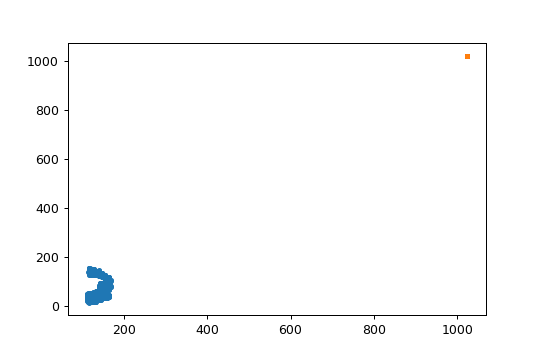

In [155]:
import matplotlib.pyplot as plt
%matplotlib notebook

plt.plot(pos[:, 0], pos[:, 1], ls='', marker='.')
plt.plot(pos[:, 2], pos[:, 3], ls='', marker='.')

In [156]:
pos_dt = np.dtype([('t', ">i4"), ('X', ">i2"), ('Y', ">i2"), ('x', ">i2"), ('y', ">i2"), 
                   ('PX', ">i2"), ('px', ">i2"), ('tot_px', ">i2"), ('unused', ">i2")])
np_pos = np.memmap(
    filename=pos_file,
    dtype=pos_dt,
    mode='r',
    offset=len(get_header_bstring(pos_file)),
    shape=(num_packets, ),
)

In [157]:
pos_dt_se = np.dtype([('t', "<i4"), ('X', "<i2"), ('Y', "<i2"), ('x', "<i2"), ('y', "<i2"), 
                   ('PX', "<i2"), ('px', "<i2"), ('tot_px', "<i2"), ('unused', "<i2")])

bin_dt = np.dtype([('id', "S4"), ('packet', "<i4"), ('di', "<i2"), ('si', "<i2"),
                   ('pos', pos_dt_se),
                   ('ephys', np.byte, 384),
                   ('trailer', np.byte, 16)
])

In [158]:
np_bin = np.memmap(
    filename=bin_file,
    dtype=bin_dt,
    mode='r',
    offset=0,
)

In [159]:
pos1s = np_bin[:16000]
len(pos1s[pos1s['id'] == b'ADU2']) 

102

In [160]:
timestamps = np.arange(len(np_bin)) / 16000
timestamps

array([0.00000000e+00, 6.25000000e-05, 1.25000000e-04, ...,
       3.00806062e+02, 3.00806125e+02, 3.00806188e+02])

In [161]:
pos_mask = [np_bin['id'] == b'ADU2']

In [162]:
pos_data = np_bin['pos'][pos_mask]

/home/sbuergers/spikeinterface/hussaini-test-pipeline/venv/lib/python3.8/site-packages/numpy/core/memmap.py:334: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  res = super(memmap, self).__getitem__(index)


In [163]:
pos_ts = timestamps[pos_mask]

/tmp/ipykernel_1189/3518797851.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pos_ts = timestamps[pos_mask]


<IPython.core.display.Javascript object>


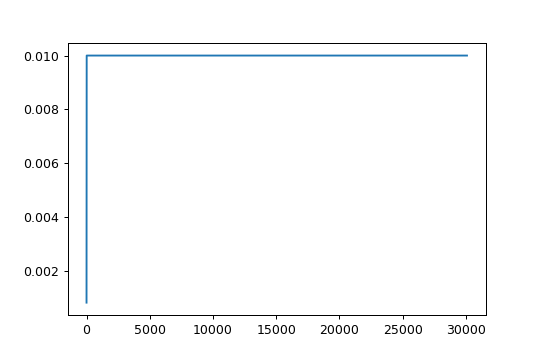

In [164]:
plt.figure()
plt.plot(np.diff(pos_ts))

In [166]:
np_bin['pos'][np_bin['id'] == b'ADU2']

array([(125330, 56, 152, 1023, 1023, 0, 16, 0, 16),
       (150120, 44, 136, 1023, 1023, 0, 11, 0, 11),
       (150120, 44, 136, 1023, 1023, 0, 11, 0, 11), ...,
       (165160, 32, 130, 1023, 1023, 0, 17, 0, 17),
       (165160, 32, 130, 1023, 1023, 0, 17, 0, 17),
       (165161, 29, 129, 1023, 1023, 0, 18, 0, 18)],
      dtype=[('t', '<i4'), ('X', '<i2'), ('Y', '<i2'), ('x', '<i2'), ('y', '<i2'), ('PX', '<i2'), ('px', '<i2'), ('tot_px', '<i2'), ('unused', '<i2')])

'/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/new_session_data/06172021-HPC-B6-RAW/06172021-HPC-B6-RAW.pos'

In [173]:
# Create .pos file from .bin file using the Hussaini lab tools

from BinConverter.core.readBin import get_bin_data, get_raw_pos
from BinConverter.core.CreatePos import create_pos

raw_position = get_raw_pos(bin_filename)

pos_file_from_bin = filename + '.pos'

create_pos(pos_file_from_bin, raw_position)

In [179]:
np_pos = np.memmap(
    filename=pos_file_from_bin,
    dtype=pos_dt,
    mode='r',
    offset=len(get_header_bstring(pos_file)),
    shape=(num_packets, ),
)

In [182]:
print(raw_position[0:3,:])

[[2357.   55.   74. 1023. 1023.    0.   17.    0.   17.]
 [2358.   56.   76. 1023. 1023.    0.   13.    0.   13.]
 [2359.   57.   74. 1023. 1023.    0.   13.    0.   13.]]


In [180]:
np_pos

memmap([(1946157065, 13568,  14080,  18947, -253, -256, 0, 4352, 0),
        ( 285212681, 13824,  14336,  19459, -253, -256, 0, 3328, 0),
        ( 218103817, 14080,  14592,  18947, -253, -256, 0, 3328, 0), ...,
        ( 201326660,  3840, -19456, -28669, -253, -256, 0, 3584, 0),
        ( 234881092,  4096, -19456, -27901, -253, -256, 0, 3840, 0),
        ( 251658308,  4352, -19456, -28413, -253, -256, 0, 3840, 0)],
       dtype=[('t', '>i4'), ('X', '>i2'), ('Y', '>i2'), ('x', '>i2'), ('y', '>i2'), ('PX', '>i2'), ('px', '>i2'), ('tot_px', '>i2'), ('unused', '>i2')])

In [178]:
np_bin['pos'][np_bin['id'] == b'ADU2']

array([(125330, 56, 152, 1023, 1023, 0, 16, 0, 16),
       (150120, 44, 136, 1023, 1023, 0, 11, 0, 11),
       (150120, 44, 136, 1023, 1023, 0, 11, 0, 11), ...,
       (165160, 32, 130, 1023, 1023, 0, 17, 0, 17),
       (165160, 32, 130, 1023, 1023, 0, 17, 0, 17),
       (165161, 29, 129, 1023, 1023, 0, 18, 0, 18)],
      dtype=[('t', '<i4'), ('X', '<i2'), ('Y', '<i2'), ('x', '<i2'), ('y', '<i2'), ('PX', '<i2'), ('px', '<i2'), ('tot_px', '<i2'), ('unused', '<i2')])

In [90]:
np_bin['pos']['X'][0]

memmap([    0, 12288,     0,     0], dtype=int16)

In [89]:
np_bin['pos']['X'], np_bin['pos']['Y']

memmap([(b'ADU1', -1929117696, 0, 256, (         0,     0,      0,    0,    0, 0,    0, 0,    0), [ -32,  -18,  120,  -24,   56,  -18,  120,  -52,  108,  -30, -124,  -22,   30,    3,   74,    9,   94,    7,  108,  -30,   60,   -1,   98,   -3,  108,  -17,  -42,  -18,   56,  -15,   92,  -22, -116,  122,   74,   -8, -102,   -6,   56,  -15,  -62,   26, -128,   13,  -60,  -16,  -40,    6,   30,   21,  -64,  -10,  -68,    6,  -80,    3,  -50,   -5,   30,   21,   -6,  -17,  -10,   13,   98,   14,  -78,    6,  -16,   40,  124,   37,   10,  -19,   44,   49,  -68,   74,  -16,   40,  -26,   -2,   34,    3,  102,   -7,  -40,    3,   16,   20,   48,   29,    2,   26,  -78,   21,  -88,   65,   16,   20, -122,    9,  -32,   -9,   30,    7,  -34,    6,  120,  -13,   14,  -12,  -94,  -88,   -4,  -54,  -50,  -19,  120,  -13,  106,   17,  -94,   22,   22,    4, -108,  -24,   50,   -1,   -4,  -24,   58,  -79,   62,    3,  118,   -8,   50,   -1,  -22,  -37,  -56,  -25,   90,  -16, -100,  -16,  -40,   -4,  

In [61]:
plt.plot(raw_pos[:, 0+1], raw_pos[:, 1+1], ls='', marker='.')
plt.plot(raw_pos[:, 2+1], raw_pos[:, 3+1], ls='', marker='.')

In [49]:
print(raw_pos[0:4, :])

[[2357.   55.   74. 1023. 1023.    0.   17.    0.   17.]
 [2358.   56.   76. 1023. 1023.    0.   13.    0.   13.]
 [2359.   57.   74. 1023. 1023.    0.   13.    0.   13.]
 [2360.   54.   78. 1023. 1023.    0.   12.    0.   12.]]


In [37]:
filename = '/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/raw_data_210621/20201004_Raw.set'
filename

'/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/raw_data_210621/20201004_Raw.set'

In [55]:
bin_file

'/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/raw_data_210621/20201004_Raw.bin'

In [54]:
bin_file = filename.split(".")[0] + ".bin"
mm = establish_mmap_to_position_data(bin_file)

bytes_packet = 432
num_packets = int(os.path.getsize(bin_file) / bytes_packet)

set_file = filename.split(".")[0] + ".set"
par = parse_generic_header(set_file, ["rawRate", "duration"])
sr_ecephys = int(par["rawRate"])

flags = np.ndarray((num_packets,), "S4", mm, 0, bytes_packet)
ADU2_idx = np.where(flags == b"ADU2")

pos = np.ndarray(
    (num_packets,), ('<i2', (1, 8)), mm, 16, (bytes_packet,)
).reshape((-1, 8))[ADU2_idx][:]

print(pos[0:4, :])

[[  48  171 1023 1023    0   10    0   10]
 [  77   56 1023 1023    0   11    0   11]
 [  74   55 1023 1023    0   17    0   17]
 [  74   55 1023 1023    0   17    0   17]]


In [48]:
print(raw_pos[0:4, :])

[[2357.   55.   74. 1023. 1023.    0.   17.    0.   17.]
 [2358.   56.   76. 1023. 1023.    0.   13.    0.   13.]
 [2359.   57.   74. 1023. 1023.    0.   13.    0.   13.]
 [2360.   54.   78. 1023. 1023.    0.   12.    0.   12.]]


In [51]:
from nwb_conversion_tools.datainterfaces.ecephys.axona.axonadatainterface import (
    read_bin_file_position_data, establish_mmap_to_position_data
)

In [ ]:
read_bin_file_position_data()

In [39]:
def find_n(iterations, optimal=1000):
    n = optimal

    while True:
        if iterations % n == 0:

            return n
        else:
            n -= 1
    return 'abort'

In [40]:
import numpy.distutils.system_info as sysinfo

In [47]:
bin_file

'/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/raw_data_210621/20201004_Raw.bin'

In [45]:
bin_filename

'/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/raw_data_210621/20201004_Raw.bin'

In [52]:
bin_filename = filename.replace('.set', '.bin')
mode = 'mmap'

byte_count = os.path.getsize(bin_filename)
bytes_per_iteration = 432
iteration_count = int(byte_count / bytes_per_iteration)
# sample_count = iteration_count * 192  # each iteration has 192 samples (64*3)

optimal_iteration = 1000000
if optimal_iteration >= iteration_count:
    simul_iterations = iteration_count
else:
    simul_iterations = find_n(iteration_count, optimal=optimal_iteration)

n = int(iteration_count / simul_iterations)  # finds how many loops to do
byte_chunksize = int(simul_iterations * bytes_per_iteration)

DaqFs = 48000
duration = iteration_count * 3 / DaqFs
duration = np.ceil(duration)

pos_Fs = 50
n_samples = int(duration * pos_Fs)

# Reading the Data

# header_byte_len = 32
# data_byte_len = 384
# trailer_byte_len = 16

raw_pos = np.array([]).astype(float)

if sysinfo.platform_bits != 64:
    mode = 'non'  # do not mmap with a 32 bit python

with open(bin_filename, 'rb') as f:

    if mode == 'mmap':
        # we will use memory mapped objects

        with contextlib.closing(mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ)) as m:
            num_iterations = int(len(m) / bytes_per_iteration)

            byte_ids = np.ndarray((num_iterations,), 'S4', m, 0, bytes_per_iteration)

            pos_bool = np.where(byte_ids == b'ADU2')  # valid position packets have an ADU2 header b'ADU2' in bytes

            valid_iterations = np.arange(len(byte_ids))[pos_bool]  # getting the packet number

            # timestamp starts at the 12th bit from the start
            time_stamp = np.ndarray((num_iterations,), np.int32, m, 12, bytes_per_iteration)[pos_bool].reshape(
                (-1, 1))  # gettinge the time stamp data

            # position values start from the 16th bit
            raw_pos = np.ndarray((num_iterations,), ('<i2', (1, 8)), m, 16,
                                 (bytes_per_iteration,)).reshape((-1, 8))[pos_bool][:]

            raw_pos = np.hstack((valid_iterations.reshape((-1, 1)), time_stamp, raw_pos)).astype(
                float)  # stacking all these values to create one matrix

    else:

        # in some cases using memory mapping will be slow, such as using 32 bit python

        iteration_start = 0
        # we will iterate
        for i in range(n):
            data = f.read(byte_chunksize)
            num_iterations = int(len(data) / bytes_per_iteration)

            byte_ids = np.ndarray((num_iterations,), 'S4', data, 0, 432)

            pos_bool = np.where(byte_ids == b'ADU2')  # valid position packets have an ADU2 header b'ADU2' in bytes

            valid_iterations = np.arange(len(byte_ids))[pos_bool]  # getting the packet number

            time_stamp = np.ndarray((num_iterations,), np.uint32, data, 12, 432)[pos_bool].reshape(
                (-1, 1))  # gettinge the time stamp data

            positions = np.ndarray((num_iterations,), (np.uint16, (1, 8)), data, 16, (432,)).reshape((-1, 8))[
                            pos_bool][:]

            i = np.add(valid_iterations,
                       iteration_start)  # offsetting the samples depending on the chunk number (n)

            positions = np.hstack((i.reshape((-1, 1)), time_stamp, positions)).astype(
                float)  # stacking all these values to create one matrix

            iteration_start += simul_iterations

            if len(raw_pos) != 0:

                raw_pos = np.vstack((raw_pos, positions))

            else:

                raw_pos = positions

    # raw_pos[:, 1] = np.divide(raw_pos[:, 1], 50)  # converting from a frame count to a time value in seconds

    # raw_pos is structured as: packet #, video timestamp, y1, x1, y2, x2, numpix1, numpix2, total_pix, unused value

    # the X and Y values are reverse piece-wise so lets switch the format from
    # packet #, video timestamp, y1, x1, y2, x2, numpix1, numpix2, total_pix, unused value
    # to
    # packet #, video timestamp, x1, y1, x2, y2, numpix1, numpix2, total_pix, unused value

    raw_pos[:, 2:6] = raw_pos[:, [3, 2, 5, 4]]

    # find the first valid sample, since the data is sampled at 48kHz, and there are 3 samples per packet, the packet
    # rate is 16kHz. The positions are sampled at 50 Hz thus there is a valid position ever 320 packets. The valid position
    # will essentially take the last ADU2 headered packet values

    first_sample_index = len(
        np.where(raw_pos[:, 0] <= 320 - 1)[0]) - 1  # subtract one since indices in python start at 0

    raw_pos = raw_pos[first_sample_index:, :]

    # there should be twice the number of samples since they double sampled to stop aliasing
    # if there is not 2 * n_samples, append the last recorded sample to the end (we will assume the animal remained there
    # for the rest of the time)

    if raw_pos.shape[0] < 2 * n_samples:
        missing_n = int(2 * n_samples - raw_pos.shape[0])
        last_location = raw_pos[-1, :]
        missing_samples = np.tile(last_location, (missing_n, 1))

        raw_pos = np.vstack((raw_pos, missing_samples))

    # now we will set the oversampled data to 1023 (NaN) as that is how the converter treats the double sampled data

    # indices = np.arange(1,raw_pos.shape[0], 2)
    indices = np.arange(0, raw_pos.shape[0], 2)
    if indices[-1] >= raw_pos.shape[0]:
        indices = indices[:-1]

    # raw_pos[indices, 2:4] = 1023
    raw_pos = raw_pos[indices, :]

    raw_pos = raw_pos[:, 1:]  # don't need the packet index anymore

In [53]:
print(raw_pos[0:4, :])

[[2357.   55.   74. 1023. 1023.    0.   17.    0.   17.]
 [2358.   56.   76. 1023. 1023.    0.   13.    0.   13.]
 [2359.   57.   74. 1023. 1023.    0.   13.    0.   13.]
 [2360.   54.   78. 1023. 1023.    0.   12.    0.   12.]]


In [36]:
from BinConverter.core.readBin import get_raw_pos

get_raw_pos(filename.replace('.set', '.bin'))

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/20201004_Raw'

In [133]:
bin_file = filename.split(".")[0] + ".bin"
mm = establish_mmap_to_position_data(bin_file)

bytes_packet = 432
num_packets = int(os.path.getsize(bin_file) / bytes_packet)

set_file = filename.split(".")[0] + ".set"
par = parse_generic_header(set_file, ["rawRate", "duration"])
sr_ecephys = int(par["rawRate"])

flags = np.ndarray((num_packets,), "S4", mm, 0, bytes_packet)
ADU2_idx = np.where(flags == b"ADU2")

pos = np.ndarray(
    (num_packets,), ('<i2', (1, 8)), mm, 16, (bytes_packet,)
).reshape((-1, 8))[ADU2_idx][:]

pos

array([[  48,  171, 1023, ...,   10,    0,   10],
       [  77,   56, 1023, ...,   11,    0,   11],
       [  74,   55, 1023, ...,   17,    0,   17],
       ...,
       [  94,  217, 1023, ...,    6,    0,    6],
       [  94,  217, 1023, ...,    6,    0,    6],
       [  93,  217, 1023, ...,   11,    0,   11]], dtype=int16)

In [128]:
bin_file = filename.split(".")[0] + ".bin"
mm = establish_mmap_to_position_data(bin_file)

bytes_packet = 432
num_packets = int(os.path.getsize(bin_file) / bytes_packet)

set_file = filename.split(".")[0] + ".set"
par = parse_generic_header(set_file, ["rawRate", "duration"])
sr_ecephys = int(par["rawRate"])

flags = np.ndarray((num_packets,), "S4", mm, 0, bytes_packet)
ADU2_idx = np.where(flags == b"ADU2")

pos = np.ndarray(
    (num_packets,), (np.int16, (1, 8)), mm, 16, (bytes_packet,)
).reshape((-1, 8))[ADU2_idx][:]

pos = np.hstack((ADU2_idx[0].reshape((-1, 1)), pos)).astype(float)

# The timestamp from the recording is dubious, create our own
packets_per_ms = sr_ecephys / 3000
pos[:, 0] = pos[:, 0] / packets_per_ms
pos = np.delete(pos, 1, 1)

In [ ]:
def read_pos_file_position_data(filename):
    """
    Reads position data from Axona .pos file and returns it as a numpy.array.

    Parameters:
    -------
    filename : path-like
        Full filename of Axona file with any extension.

    Returns:
    -------
    pos : np.array
    
    Notes:
    ------
    Only supports two-spot mode at the moment.
    """
    
    pos_file = filename.split(".")[0] + ".pos"
    mm = establish_mmap_to_position_data(pos_file)
    
    bytes_packet = 20
    footer_size = len('\r\ndata_end\r\n')
    header_size = len(get_header_bstring(pos_file))
    num_bytes = os.path.getsize(pos_file) - header_size - footer_size
    num_packets = num_bytes // bytes_packet

    set_file = filename.split(".")[0] + ".set"
    par = parse_generic_header(set_file, ["rawRate", "duration"])
    sr_ecephys = int(par["rawRate"])
    
    pos = np.ndarray(
        shape=(num_packets,), 
        dtype=('>i2', 8),
        buffer=mmpos,
        offset=len(get_header_bstring(pos_file)) + 4,
        strides=bytes_packet
    )

    # The timestamp from the recording is dubious, but if we only have a
    # .pos file, we cannot construct a meaningful one wrt the ecephys recording.
    # The user has to pass it themselves.
    packets_per_ms = sr_ecephys / 3000
    pos[:, 0] = pos[:, 0] / packets_per_ms
    pos = np.delete(pos, 1, 1)

    return pos

In [125]:
time_stamp = np.ndarray(
    shape=(num_packets,), 
    dtype='>i4', 
    buffer=mmpos,
    offset=532,
    strides=20
).reshape((-1, 1))
time_stamp

array([[2357],
       [2358],
       [2359],
       [2360],
       [2361],
       [2362],
       [2363],
       [2364],
       [2365],
       [2366],
       [2367],
       [2368],
       [2369],
       [2370],
       [2371],
       [2372],
       [2373],
       [2374],
       [2375],
       [2376],
       [2377],
       [2378],
       [2379],
       [2380],
       [2381],
       [2382],
       [2383],
       [2384],
       [2385],
       [2386],
       [2387],
       [2388],
       [2389],
       [2390],
       [2391],
       [2392],
       [2393],
       [2394],
       [2395],
       [2396],
       [2397],
       [2398],
       [2399],
       [2400],
       [2401],
       [2402],
       [2403],
       [2404],
       [2405],
       [2406],
       [2407],
       [2408],
       [2409],
       [2410],
       [2411],
       [2412],
       [2413],
       [2414],
       [2415],
       [2416],
       [2416],
       [2416],
       [2416],
       [2416],
       [2416],
       [2416],
       [24

In [126]:
pos = np.ndarray(
    shape=(num_packets,), 
    dtype=('>i2', 8),
    buffer=mmpos,
    offset=len(get_header_bstring(pos_file)) + 4,
    strides=bytes_packet
)
pos

array([[  55,   74, 1023, 1023,    0,   17,    0,   17],
       [  56,   76, 1023, 1023,    0,   13,    0,   13],
       [  57,   74, 1023, 1023,    0,   13,    0,   13],
       [  54,   78, 1023, 1023,    0,   12,    0,   12],
       [  54,   76, 1023, 1023,    0,   11,    0,   11],
       [  60,   75, 1023, 1023,    0,   13,    0,   13],
       [  59,   74, 1023, 1023,    0,   12,    0,   12],
       [  60,   76, 1023, 1023,    0,   11,    0,   11],
       [  54,   77, 1023, 1023,    0,   10,    0,   10],
       [  59,   76, 1023, 1023,    0,   10,    0,   10],
       [  56,   75, 1023, 1023,    0,   12,    0,   12],
       [  55,   77, 1023, 1023,    0,    9,    0,    9],
       [  61,   76, 1023, 1023,    0,    7,    0,    7],
       [  57,   79, 1023, 1023,    0,   10,    0,   10],
       [  61,   77, 1023, 1023,    0,    8,    0,    8],
       [  59,   74, 1023, 1023,    0,    6,    0,    6],
       [  60,   71, 1023, 1023,    0,    7,    0,    7],
       [  59,   72, 1023, 1023,

In [127]:
np.hstack((time_stamp, raw_pos)).astype(float)

array([[2357.,   55.,   74., 1023., 1023.,    0.,   17.,    0.,   17.],
       [2358.,   56.,   76., 1023., 1023.,    0.,   13.,    0.,   13.],
       [2359.,   57.,   74., 1023., 1023.,    0.,   13.,    0.,   13.],
       [2360.,   54.,   78., 1023., 1023.,    0.,   12.,    0.,   12.],
       [2361.,   54.,   76., 1023., 1023.,    0.,   11.,    0.,   11.],
       [2362.,   60.,   75., 1023., 1023.,    0.,   13.,    0.,   13.],
       [2363.,   59.,   74., 1023., 1023.,    0.,   12.,    0.,   12.],
       [2364.,   60.,   76., 1023., 1023.,    0.,   11.,    0.,   11.],
       [2365.,   54.,   77., 1023., 1023.,    0.,   10.,    0.,   10.],
       [2366.,   59.,   76., 1023., 1023.,    0.,   10.,    0.,   10.],
       [2367.,   56.,   75., 1023., 1023.,    0.,   12.,    0.,   12.],
       [2368.,   55.,   77., 1023., 1023.,    0.,    9.,    0.,    9.],
       [2369.,   61.,   76., 1023., 1023.,    0.,    7.,    0.,    7.],
       [2370.,   57.,   79., 1023., 1023.,    0.,   10.,    0., 

In [62]:
dir_name = Path('/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_units/Axona_Unit_Mode_SmallFile')
base_filename = '20140815-180secs'
pos_file = dir_name / (base_filename + '.pos')

mmpos = establish_mmap_to_pos_file(pos_file)

time_stamp = np.ndarray(
    shape=(num_packets,), 
    dtype='>i4', 
    buffer=mmpos,
    offset=532,
    strides=20
)

pos = np.ndarray(
    shape=(num_packets,), 
    dtype=('>i2', 8),
    buffer=mmpos,
    offset=len(get_header_bstring(pos_file)) + 4,
    strides=bytes_packet
)
pos = pos.astype(float)

# The timestamp from the recording is dubious, create our own
sr_ecephys = 48000
packets_per_ms = sr_ecephys / 3000
time_stamp = pos[:, 0] / packets_per_ms

pos

array([[     0,      0,   2560, -15616,   -253,   -253,   1024,      0,
          1024,      0],
       [     0,    256,   3072, -16384,   -253,   -253,   1536,      0,
          1536,      0],
       [     0,    512,   1536, -15872,   -253,   -253,   2048,      0,
          2048,      0],
       [     0,    768,   2048, -16896,   -253,   -253,   3584,      0,
          3584,      0],
       [     0,   1024,   1536, -16640,   -253,   -253,   3328,      0,
          3328,      0],
       [     0,   1280,   1280, -17408,   -253,   -253,   3840,      0,
          3840,      0],
       [     0,   1536,   1792, -17408,   -253,   -253,   3584,      0,
          3584,      0],
       [     0,   1792,   1536, -18432,   -253,   -253,   3840,      0,
          3840,      0],
       [     0,   2048,   1536, -18688,   -253,   -253,   4864,      0,
          4864,      0],
       [     0,   2304,   1536, -19712,   -253,   -253,   4096,      0,
          4096,      0],
       [     0,   2560,   1536

In [222]:
filename = pos_file

bin_file = filename.split(".")[0] + ".bin"
mm = establish_mmap_to_position_data(bin_file)

bytes_packet = 432
num_packets = int(os.path.getsize(bin_file) / bytes_packet)

set_file = filename.split(".")[0] + ".set"
par = parse_generic_header(set_file, ["rawRate", "duration"])
sr_ecephys = int(par["rawRate"])

flags = np.ndarray((num_packets,), "S4", mm, 0, bytes_packet)
ADU2_idx = np.where(flags == b"ADU2")

pos = np.ndarray(
    (num_packets,), (np.int16, (1, 8)), mm, 16, (bytes_packet,)
).reshape((-1, 8))[ADU2_idx][:]

In [223]:
pos

array([[  48,  171, 1023, 1023,    0,   10,    0,   10],
       [  77,   56, 1023, 1023,    0,   11,    0,   11],
       [  74,   55, 1023, 1023,    0,   17,    0,   17],
       [  74,   55, 1023, 1023,    0,   17,    0,   17],
       [  76,   56, 1023, 1023,    0,   13,    0,   13],
       [  76,   56, 1023, 1023,    0,   13,    0,   13],
       [  74,   57, 1023, 1023,    0,   13,    0,   13],
       [  74,   57, 1023, 1023,    0,   13,    0,   13],
       [  78,   54, 1023, 1023,    0,   12,    0,   12],
       [  78,   54, 1023, 1023,    0,   12,    0,   12],
       [  76,   54, 1023, 1023,    0,   11,    0,   11],
       [  76,   54, 1023, 1023,    0,   11,    0,   11],
       [  75,   60, 1023, 1023,    0,   13,    0,   13],
       [  75,   60, 1023, 1023,    0,   13,    0,   13],
       [  74,   59, 1023, 1023,    0,   12,    0,   12],
       [  74,   59, 1023, 1023,    0,   12,    0,   12],
       [  76,   60, 1023, 1023,    0,   11,    0,   11],
       [  76,   60, 1023, 1023,

In [169]:
pos = np.hstack((ADU2_idx[0].reshape((-1, 1)), pos)).astype(float)

# The timestamp from the recording is dubious, create our own
packets_per_ms = sr_ecephys / 3000
pos[:, 0] = pos[:, 0] / packets_per_ms
pos = np.delete(pos, 1, 1)

array([[6.250000e-02, 1.710000e+02, 1.023000e+03, 1.023000e+03,
        0.000000e+00, 1.000000e+01, 0.000000e+00, 1.000000e+01],
       [8.750000e-01, 5.600000e+01, 1.023000e+03, 1.023000e+03,
        0.000000e+00, 1.100000e+01, 0.000000e+00, 1.100000e+01],
       [6.375000e+00, 5.500000e+01, 1.023000e+03, 1.023000e+03,
        0.000000e+00, 1.700000e+01, 0.000000e+00, 1.700000e+01],
       [1.637500e+01, 5.500000e+01, 1.023000e+03, 1.023000e+03,
        0.000000e+00, 1.700000e+01, 0.000000e+00, 1.700000e+01],
       [2.637500e+01, 5.600000e+01, 1.023000e+03, 1.023000e+03,
        0.000000e+00, 1.300000e+01, 0.000000e+00, 1.300000e+01],
       [3.637500e+01, 5.600000e+01, 1.023000e+03, 1.023000e+03,
        0.000000e+00, 1.300000e+01, 0.000000e+00, 1.300000e+01],
       [4.637500e+01, 5.700000e+01, 1.023000e+03, 1.023000e+03,
        0.000000e+00, 1.300000e+01, 0.000000e+00, 1.300000e+01],
       [5.637500e+01, 5.700000e+01, 1.023000e+03, 1.023000e+03,
        0.000000e+00, 1.300000e+0

In [132]:
read_bin_file_position_data(pos_file.replace('.pos', '.bin'))

array([[6.250000e-02, 1.710000e+02, 1.023000e+03, 1.023000e+03,
        0.000000e+00, 1.000000e+01, 0.000000e+00, 1.000000e+01],
       [8.750000e-01, 5.600000e+01, 1.023000e+03, 1.023000e+03,
        0.000000e+00, 1.100000e+01, 0.000000e+00, 1.100000e+01],
       [6.375000e+00, 5.500000e+01, 1.023000e+03, 1.023000e+03,
        0.000000e+00, 1.700000e+01, 0.000000e+00, 1.700000e+01],
       [1.637500e+01, 5.500000e+01, 1.023000e+03, 1.023000e+03,
        0.000000e+00, 1.700000e+01, 0.000000e+00, 1.700000e+01],
       [2.637500e+01, 5.600000e+01, 1.023000e+03, 1.023000e+03,
        0.000000e+00, 1.300000e+01, 0.000000e+00, 1.300000e+01],
       [3.637500e+01, 5.600000e+01, 1.023000e+03, 1.023000e+03,
        0.000000e+00, 1.300000e+01, 0.000000e+00, 1.300000e+01],
       [4.637500e+01, 5.700000e+01, 1.023000e+03, 1.023000e+03,
        0.000000e+00, 1.300000e+01, 0.000000e+00, 1.300000e+01],
       [5.637500e+01, 5.700000e+01, 1.023000e+03, 1.023000e+03,
        0.000000e+00, 1.300000e+0

In [127]:
mmpos[0:len(get_header_bstring(pos_file))]

b'trial_date Sunday, 4 Oct 2020\r\ntrial_time 11:07:07\r\nexperimenter Abid\r\ncomments \r\nduration 1.2\r\nsw_version 1.2.2.16\r\nnum_colours 4\r\nmin_x 0\r\nmax_x 768\r\nmin_y 0\r\nmax_y 574\r\nwindow_min_x 181\r\nwindow_max_x 481\r\nwindow_min_y 98\r\nwindow_max_y 348\r\ntimebase 50 hz\r\nbytes_per_timestamp 4\r\nsample_rate 50.0 hz\r\nEEG_samples_per_position 5\r\nbearing_colour_1 0\r\nbearing_colour_2 0\r\nbearing_colour_3 0\r\nbearing_colour_4 0\r\npos_format t,x1,y1,x2,y2,numpix1,numpix2\r\nbytes_per_coord 2\r\npixels_per_metre 300.000000\r\nnum_pos_samples 100\r\ndata_start'

In [130]:
mmpos_bin[0:10]

b'ADU1\x8d\x04\x00\x00\x00\x00'

In [128]:
mmpos[len(get_header_bstring(pos_file))::]

b'\x00\x00\t5\x007\x00J\x03\xff\x03\xff\x00\x00\x00\x11\x00\x00\x00\x11\x00\x00\t6\x008\x00L\x03\xff\x03\xff\x00\x00\x00\r\x00\x00\x00\r\x00\x00\t7\x009\x00J\x03\xff\x03\xff\x00\x00\x00\r\x00\x00\x00\r\x00\x00\t8\x006\x00N\x03\xff\x03\xff\x00\x00\x00\x0c\x00\x00\x00\x0c\x00\x00\t9\x006\x00L\x03\xff\x03\xff\x00\x00\x00\x0b\x00\x00\x00\x0b\x00\x00\t:\x00<\x00K\x03\xff\x03\xff\x00\x00\x00\r\x00\x00\x00\r\x00\x00\t;\x00;\x00J\x03\xff\x03\xff\x00\x00\x00\x0c\x00\x00\x00\x0c\x00\x00\t<\x00<\x00L\x03\xff\x03\xff\x00\x00\x00\x0b\x00\x00\x00\x0b\x00\x00\t=\x006\x00M\x03\xff\x03\xff\x00\x00\x00\n\x00\x00\x00\n\x00\x00\t>\x00;\x00L\x03\xff\x03\xff\x00\x00\x00\n\x00\x00\x00\n\x00\x00\t?\x008\x00K\x03\xff\x03\xff\x00\x00\x00\x0c\x00\x00\x00\x0c\x00\x00\t@\x007\x00M\x03\xff\x03\xff\x00\x00\x00\t\x00\x00\x00\t\x00\x00\tA\x00=\x00L\x03\xff\x03\xff\x00\x00\x00\x07\x00\x00\x00\x07\x00\x00\tB\x009\x00O\x03\xff\x03\xff\x00\x00\x00\n\x00\x00\x00\n\x00\x00\tC\x00=\x00M\x03\xff\x03\xff\x00\x00\x00\x08\x00\x0

In [73]:
def establish_mmap_to_position_data(filename):
    """
    Generates a memory map (mmap) object connected to an Axona .pos
    file.

    Parameters:
    -------
    filename (Path or Str): 
        Full filename of Axona .pos file.

    Returns:
    -------
    mm (mmap or None): 
        Memory map to .bin file position data
    """
    mmpos = None

    set_file = filename.split(".")[0] + ".set"
    par = parse_generic_header(set_file, None)

    num_packets = int(os.path.getsize(bin_file) / bytes_packet)
    num_ecephys_samples = num_packets * 3
    dur_ecephys = num_ecephys_samples / sr_ecephys
    assert dur_ecephys == float(par["duration"])

    # memory mapping position data
    # Note: The first 4 bytes are a timestamp, and the last 2 bytes are empty!
    pos_data = np.memmap(
        filename,
        dtype=np.int16,
        mode='r', offset=header_size,
        shape=(num_samples, 10)
    )
    pos_timestamps = np.memmap(
        filename,
        dtype=np.int32,
        mode='r', offset=header_size,
        shape=(num_samples, )
    )

    return mmpos

# Intan to NWB

For this there are already resources from the Hussaini lab we should be able to use.

See here: ...

In [39]:
from nwb_conversion_tools import (
    NWBConverter, AxonaRecordingExtractorInterface, AxonaPositionDataInterface, IntanRecordingInterface
)

In [40]:
from nwb_conversion_tools import IntanRecordingInterface

In [41]:
class HussainiIntanNWBConverter(NWBConverter):
    data_interface_classes = dict(
        IntanRecordingInterface=IntanRecordingInterface,
    )

In [42]:
intan_file = '/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/Intan_data/intan_rhd_test_1.rhd'

In [43]:
# Specify source data

source_data = dict(
    IntanRecordingInterface=dict(
        file_path=intan_file
    )
)
print(json.dumps(source_data, indent=2))

{
  "IntanRecordingInterface": {
    "file_path": "/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/Intan_data/intan_rhd_test_1.rhd"
  }
}


In [44]:
# Initialize HussainiIntanNWBConverter

intan_converter = HussainiIntanNWBConverter(source_data=source_data)

Source data is valid!


In [45]:
# Get metadata_schema from converter

metadata_schema = intan_converter.get_metadata_schema()

print(json.dumps(metadata_schema['properties'], indent=2))

{
  "NWBFile": {
    "required": [
      "session_description",
      "identifier",
      "session_start_time"
    ],
    "properties": {
      "session_description": {
        "type": "string",
        "format": "long",
        "description": "a description of the session where this data was generated",
        "default": "no description"
      },
      "identifier": {
        "type": "string",
        "description": "a unique text identifier for the file",
        "default": "74a1b10c-84a8-4a5f-8a2d-9ea071e282b4"
      },
      "session_start_time": {
        "type": "string",
        "description": "the start date and time of the recording session",
        "format": "date-time",
        "default": "1970-01-01T00:00:00"
      },
      "experimenter": {
        "type": "array",
        "items": {
          "type": "string",
          "title": "experimenter"
        },
        "description": "name of person who performed experiment"
      },
      "experiment_description": {
        "

In [46]:
# Validate metadata against metadata_schema

validate(
    instance=intan_converter.get_metadata(),
    schema=intan_converter.get_metadata_schema()
)

ValidationError: Additional properties are not allowed ('ElectricalSeries_raw' was unexpected)

Failed validating 'additionalProperties' in schema['properties']['Ecephys']:
    {'additionalProperties': False,
     'properties': {'Device': {'default': [{}],
                               'items': {'$ref': '#/properties/Ecephys/properties/definitions/Device'},
                               'minItems': 1,
                               'type': 'array'},
                    'ElectrodeGroup': {'default': [{'description': 'Group '
                                                                   'B '
                                                                   'electrodes.',
                                                    'name': 'GroupB'},
                                                   {'description': 'Group '
                                                                   'A '
                                                                   'electrodes.',
                                                    'name': 'GroupA'},
                                                   {'description': 'Group '
                                                                   'C '
                                                                   'electrodes.',
                                                    'name': 'GroupC'}],
                                       'items': {'$ref': '#/properties/Ecephys/properties/definitions/ElectrodeGroup'},
                                       'minItems': 1,
                                       'type': 'array'},
                    'Electrodes': {'default': [{'description': 'The name '
                                                               'of the '
                                                               'ElectrodeGroup '
                                                               'this '
                                                               'electrode '
                                                               'is a part '
                                                               'of.',
                                                'name': 'group_name'},
                                               {'data': [[0,
                                                          1,
                                                          2,
                                                          3,
                                                          4,
                                                          5,
                                                          6,
                                                          7,
                                                          8,
                                                          9,
                                                          10,
                                                          11,
                                                          12,
                                                          13,
                                                          14,
                                                          15,
                                                          16,
                                                          17,
                                                          18,
                                                          19,
                                                          20,
                                                          21,
                                                          22,
                                                          23,
                                                          24,
                                                          25,
                                                          26,
                                                          27,
                                                          28,
                                                          29,
                                                          30,
                                                          31,
                                                          32,
                                                          33,
                                                          34,
                                                          35,
                                                          36,
                                                          37,
                                                          38,
                                                          39,
                                                          40,
                                                          41,
                                                          42,
                                                          43,
                                                          44,
                                                          45,
                                                          46,
                                                          47,
                                                          48,
                                                          49,
                                                          50,
                                                          51,
                                                          52,
                                                          53,
                                                          54,
                                                          55,
                                                          56,
                                                          57,
                                                          58,
                                                          59,
                                                          60,
                                                          61,
                                                          62,
                                                          63,
                                                          0,
                                                          1,
                                                          2,
                                                          3,
                                                          4,
                                                          5,
                                                          6,
                                                          7,
                                                          8,
                                                          9,
                                                          10,
                                                          11,
                                                          12,
                                                          13,
                                                          14,
                                                          15,
                                                          16,
                                                          17,
                                                          18,
                                                          19,
                                                          20,
                                                          21,
                                                          22,
                                                          23,
                                                          24,
                                                          25,
                                                          26,
                                                          27,
                                                          28,
                                                          29,
                                                          30,
                                                          31,
                                                          32,
                                                          33,
                                                          34,
                                                          35,
                                                          36,
                                                          37,
                                                          38,
                                                          39,
                                                          40,
                                                          41,
                                                          42,
                                                          43,
                                                          44,
                                                          45,
                                                          46,
                                                          47,
                                                          48,
                                                          49,
                                                          50,
                                                          51,
                                                          52,
                                                          53,
                                                          54,
                                                          55,
                                                          56,
                                                          57,
                                                          58,
                                                          59,
                                                          60,
                                                          61,
                                                          62,
                                                          63,
                                                          0,
                                                          1,
                                                          2,
                                                          3,
                                                          4,
                                                          5,
                                                          6,
                                                          7,
                                                          8,
                                                          9,
                                                          10,
                                                          11,
                                                          12,
                                                          13,
                                                          14,
                                                          15,
                                                          16,
                                                          17,
                                                          18,
                                                          19,
                                                          20,
                                                          21,
                                                          22,
                                                          23,
                                                          24,
                                                          25,
                                                          26,
                                                          27,
                                                          28,
                                                          29,
                                                          30,
                                                          31,
                                                          32,
                                                          33,
                                                          34,
                                                          35,
                                                          36,
                                                          37,
                                                          38,
                                                          39,
                                                          40,
                                                          41,
                                                          42,
                                                          43,
                                                          44,
                                                          45,
                                                          46,
                                                          47,
                                                          48,
                                                          49,
                                                          50,
                                                          51,
                                                          52,
                                                          53,
                                                          54,
                                                          55,
                                                          56,
                                                          57,
                                                          58,
                                                          59,
                                                          60,
                                                          61,
                                                          62,
                                                          63]],
                                                'description': '0-indexed '
                                                               'channel '
                                                               'within a '
                                                               'group.',
                                                'name': 'group_electrode_number'},
                                               {'data': ['F1-01',
                                                         'F1-02',
                                                         'F1-03',
                                                         'F1-04',
                                                         'F1-05',
                                                         'F1-06',
                                                         'F1-07',
                                                         'F1-08',
                                                         'F1-09',
                                                         'F1-10',
                                                         'F1-11',
                                                         'F1-12',
                                                         'F1-13',
                                                         'F1-14',
                                                         'F1-15',
                                                         'F1-16',
                                                         'F1-17',
                                                         'F1-18',
                                                         'F1-19',
                                                         'F1-20',
                                                         'F1-21',
                                                         'F1-22',
                                                         'F1-23',
                                                         'F1-24',
                                                         'F1-25',
                                                         'F1-26',
                                                         'F1-27',
                                                         'F1-28',
                                                         'F1-29',
                                                         'F1-30',
                                                         'F1-31',
                                                         'F1-32',
                                                         'F5(HAND)-01',
                                                         'F5(HAND)-02',
                                                         'F5(HAND)-03',
                                                         'F5(HAND)-04',
                                                         'F5(HAND)-05',
                                                         'F5(HAND)-06',
                                                         'F5(HAND)-07',
                                                         'F5(HAND)-08',
                                                         'F5(hand)-09',
                                                         'F5(HAND)-10',
                                                         'F5(HAND)-11',
                                                         'F5(HAND)-12',
                                                         'F5(HAND)-13',
                                                         'F5(HAND)-14',
                                                         'F5(HAND)-15',
                                                         'F5(HAND)-16',
                                                         'F5(HAND)-17',
                                                         'F5(HAND)-18',
                                                         'F5(HAND)-19',
                                                         'F5(HAND)-20',
                                                         'F5(HAND)-21',
                                                         'F5(HAND)-22',
                                                         'F5(HAND)-23',
                                                         'F5(HAND)-24',
                                                         'F5(HAND)-25',
                                                         'F5(HAND)-26',
                                                         'F5(HAND)-27',
                                                         'F5(HAND)-28',
                                                         'F5(HAND)-29',
                                                         'F5(HAND)-30',
                                                         'F5(HAND)-31',
                                                         'F5(HAND)-32',
                                                         'F5(MOUTH)-01',
                                                         'F5(MOUTH)-02',
                                                         'F5(MOUTH)-03',
                                                         'F5(MOUTH)-04',
                                                         'F5(MOUTH)-05',
                                                         'F5(MOUTH)-06',
                                                         'F5(MOUTH)-07',
                                                         'F5(MOUTH)-08',
                                                         'F5(MOUTH)-09',
                                                         'F5(MOUTH)-10',
                                                         'F5(MOUTH)-11',
                                                         'F5(MOUTH)-12',
                                                         'F5(MOUTH)-13',
                                                         'F5(MOUTH)-14',
                                                         'F5(MOUTH)-15',
                                                         'F5(MOUTH)-16',
                                                         'F5(MOUTH)-17',
                                                         'F5(MOUTH)-18',
                                                         'F5(MOUTH)-19',
                                                         'F5(MOUTH)-20',
                                                         'F5(MOUTH)-21',
                                                         'F5(MOUTH)-22',
                                                         'F5(MOUTH)-23',
                                                         'F5(MOUTH)-24',
                                                         'F5(MOUTH)-25',
                                                         'F5(MOUTH)-26',
                                                         'F5(MOUTH)-27',
                                                         'F5(MOUTH)-28',
                                                         'F5(MOUTH)-29',
                                                         'F5(MOUTH)-30',
                                                         'F5(MOUTH)-31',
                                                         'F5(MOUTH)-32',
                                                         '46v/12r-01',
                                                         '46v/12r-02',
                                                         '46v/12r-03',
                                                         '46v/12r-04',
                                                         '46v/12r-05',
                                                         '46v/12r-06',
                                                         '46v/12r-07',
                                                         '46v/12r-08',
                                                         '46v/12r-09',
                                                         '46v/12r-10',
                                                         '46v/12r-11',
                                                         '46v/12r-12',
                                                         '46v/12r-13',
                                                         '46v/12r-14',
                                                         '46v/12r-15',
                                                         '46v/12r-16',
                                                         '46v/12r-17',
                                                         '46v/12r-18',
                                                         '46v/12r-19',
                                                         '46v/12r-20',
                                                         '46v/12r-21',
                                                         '46v/12r-22',
                                                         '46v/12r-23',
                                                         '46v/12r-24',
                                                         '46v/12r-25',
                                                         '46v/12r-26',
                                                         '46v/12r-27',
                                                         '46v/12r-28',
                                                         '46v/12r-29',
                                                         '46v/12r-30',
                                                         '46v/12r-31',
                                                         '46v/12r-32',
                                                         '45A-01',
                                                         '45A-02',
                                                         '45A-03',
                                                         '45A-04',
                                                         '45A-05',
                                                         '45A-06',
                                                         '45A-07',
                                                         '45A-08',
                                                         '45A-09',
                                                         '45A-10',
                                                         '45A-11',
                                                         '45A-12',
                                                         '45A-13',
                                                         '45A-14',
                                                         '45A-15',
                                                         '45A-16',
                                                         '45A-17',
                                                         '45A-18',
                                                         '45A-19',
                                                         '45A-20',
                                                         '45A-21',
                                                         '45A-22',
                                                         '45A-23',
                                                         '45A-24',
                                                         '45A-25',
                                                         '45A-26',
                                                         '45A-27',
                                                         '45A-28',
                                                         '45A-29',
                                                         '45A-30',
                                                         '45A-31',
                                                         '45A-32',
                                                         'F2-01',
                                                         'F2-02',
                                                         'F2-03',
                                                         'F2-04',
                                                         'F2-05',
                                                         'F2-06',
                                                         'F2-07',
                                                         'F2-08',
                                                         'F2-09',
                                                         'F2-10',
                                                         'F2-11',
                                                         'F2-12',
                                                         'F2-13',
                                                         'F2-14',
                                                         'F2-15',
                                                         'F2-16',
                                                         'F2-17',
                                                         'F2-18',
                                                         'F2-19',
                                                         'F2-20',
                                                         'F2-21',
                                                         'F2-22',
                                                         'F2-23',
                                                         'F2-24',
                                                         'F2-25',
                                                         'F2-26',
                                                         'F2-27',
                                                         'F2-28',
                                                         'F2-29',
                                                         'F2-30',
                                                         'F2-31',
                                                         'F2-32'],
                                                'description': 'Custom '
                                                               'channel '
                                                               'name '
                                                               'assigned '
                                                               'in Intan.',
                                                'name': 'custom_channel_name'}],
                                   'items': {'$ref': '#/properties/Ecephys/properties/definitions/Electrodes'},
                                   'minItems': 0,
                                   'renderForm': False,
                                   'type': 'array'},
                    'definitions': {'Device': {'additionalProperties': False,
                                               'properties': {'description': {'description': 'Description '
                                                                                             'of '
                                                                                             'the '
                                                                                             'device '
                                                                                             '(e.g., '
                                                                                             'model, '
                                                                                             'firmware '
                                                                                             'version, '
                                                                                             'processing '
                                                                                             'software '
                                                                                             'version, '
                                                                                             'etc.)',
                                                                              'type': 'string'},
                                                              'manufacturer': {'description': 'the '
                                                                                              'name '
                                                                                              'of '
                                                                                              'the '
                                                                                              'manufacturer '
                                                                                              'of '
                                                                                              'this '
                                                                                              'device',
                                                                               'type': 'string'},
                                                              'name': {'description': 'the '
                                                                                      'name '
                                                                                      'of '
                                                                                      'this '
                                                                                      'device',
                                                                       'type': 'string'}},
                                               'required': ['name'],
                                               'tag': 'pynwb.device.Device',
                                               'type': 'object'},
                                    'ElectrodeGroup': {'additionalProperties': False,
                                                       'properties': {'description': {'description': 'description '
                                                                                                     'of '
                                                                                                     'this '
                                                                                                     'electrode '
                                                                                                     'group',
                                                                                      'type': 'string'},
                                                                      'device': {'description': 'the '
                                                                                                'device '
                                                                                                'that '
                                                                                                'was '
                                                                                                'used '
                                                                                                'to '
                                                                                                'record '
                                                                                                'from '
                                                                                                'this '
                                                                                                'electrode '
                                                                                                'group',
                                                                                 'target': 'pynwb.device.Device',
                                                                                 'type': 'string'},
                                                                      'location': {'description': 'description '
                                                                                                  'of '
                                                                                                  'location '
                                                                                                  'of '
                                                                                                  'this '
                                                                                                  'electrode '
                                                                                                  'group',
                                                                                   'type': 'string'},
                                                                      'name': {'description': 'the '
                                                                                              'name '
                                                                                              'of '
                                                                                              'this '
                                                                                              'electrode',
                                                                               'type': 'string'}},
                                                       'required': ['location',
                                                                    'name',
                                                                    'description',
                                                                    'device'],
                                                       'tag': 'pynwb.ecephys.ElectrodeGroup',
                                                       'type': 'object'},
                                    'Electrodes': {'additionalProperties': False,
                                                   'properties': {'description': {'description': 'description '
                                                                                                 'of '
                                                                                                 'this '
                                                                                                 'electrodes '
                                                                                                 'column',
                                                                                  'type': 'string'},
                                                                  'name': {'description': 'name '
                                                                                          'of '
                                                                                          'this '
                                                                                          'electrodes '
                                                                                          'column',
                                                                           'type': 'string'}},
                                                   'required': ['name'],
                                                   'type': 'object'}}},
     'required': ['Device', 'ElectrodeGroup'],
     'tag': 'Ecephys',
     'type': 'object'}

On instance['Ecephys']:
    {'Device': [{}],
     'ElectricalSeries_raw': {'description': 'Raw acquisition traces.',
                              'name': 'ElectricalSeries_raw'},
     'ElectrodeGroup': [{'description': 'Group B electrodes.',
                         'name': 'GroupB'},
                        {'description': 'Group A electrodes.',
                         'name': 'GroupA'},
                        {'description': 'Group C electrodes.',
                         'name': 'GroupC'}],
     'Electrodes': [{'description': 'The name of the ElectrodeGroup this '
                                    'electrode is a part of.',
                     'name': 'group_name'},
                    {'data': [[0,
                               1,
                               2,
                               3,
                               4,
                               5,
                               6,
                               7,
                               8,
                               9,
                               10,
                               11,
                               12,
                               13,
                               14,
                               15,
                               16,
                               17,
                               18,
                               19,
                               20,
                               21,
                               22,
                               23,
                               24,
                               25,
                               26,
                               27,
                               28,
                               29,
                               30,
                               31,
                               32,
                               33,
                               34,
                               35,
                               36,
                               37,
                               38,
                               39,
                               40,
                               41,
                               42,
                               43,
                               44,
                               45,
                               46,
                               47,
                               48,
                               49,
                               50,
                               51,
                               52,
                               53,
                               54,
                               55,
                               56,
                               57,
                               58,
                               59,
                               60,
                               61,
                               62,
                               63,
                               0,
                               1,
                               2,
                               3,
                               4,
                               5,
                               6,
                               7,
                               8,
                               9,
                               10,
                               11,
                               12,
                               13,
                               14,
                               15,
                               16,
                               17,
                               18,
                               19,
                               20,
                               21,
                               22,
                               23,
                               24,
                               25,
                               26,
                               27,
                               28,
                               29,
                               30,
                               31,
                               32,
                               33,
                               34,
                               35,
                               36,
                               37,
                               38,
                               39,
                               40,
                               41,
                               42,
                               43,
                               44,
                               45,
                               46,
                               47,
                               48,
                               49,
                               50,
                               51,
                               52,
                               53,
                               54,
                               55,
                               56,
                               57,
                               58,
                               59,
                               60,
                               61,
                               62,
                               63,
                               0,
                               1,
                               2,
                               3,
                               4,
                               5,
                               6,
                               7,
                               8,
                               9,
                               10,
                               11,
                               12,
                               13,
                               14,
                               15,
                               16,
                               17,
                               18,
                               19,
                               20,
                               21,
                               22,
                               23,
                               24,
                               25,
                               26,
                               27,
                               28,
                               29,
                               30,
                               31,
                               32,
                               33,
                               34,
                               35,
                               36,
                               37,
                               38,
                               39,
                               40,
                               41,
                               42,
                               43,
                               44,
                               45,
                               46,
                               47,
                               48,
                               49,
                               50,
                               51,
                               52,
                               53,
                               54,
                               55,
                               56,
                               57,
                               58,
                               59,
                               60,
                               61,
                               62,
                               63]],
                     'description': '0-indexed channel within a group.',
                     'name': 'group_electrode_number'},
                    {'data': ['F1-01',
                              'F1-02',
                              'F1-03',
                              'F1-04',
                              'F1-05',
                              'F1-06',
                              'F1-07',
                              'F1-08',
                              'F1-09',
                              'F1-10',
                              'F1-11',
                              'F1-12',
                              'F1-13',
                              'F1-14',
                              'F1-15',
                              'F1-16',
                              'F1-17',
                              'F1-18',
                              'F1-19',
                              'F1-20',
                              'F1-21',
                              'F1-22',
                              'F1-23',
                              'F1-24',
                              'F1-25',
                              'F1-26',
                              'F1-27',
                              'F1-28',
                              'F1-29',
                              'F1-30',
                              'F1-31',
                              'F1-32',
                              'F5(HAND)-01',
                              'F5(HAND)-02',
                              'F5(HAND)-03',
                              'F5(HAND)-04',
                              'F5(HAND)-05',
                              'F5(HAND)-06',
                              'F5(HAND)-07',
                              'F5(HAND)-08',
                              'F5(hand)-09',
                              'F5(HAND)-10',
                              'F5(HAND)-11',
                              'F5(HAND)-12',
                              'F5(HAND)-13',
                              'F5(HAND)-14',
                              'F5(HAND)-15',
                              'F5(HAND)-16',
                              'F5(HAND)-17',
                              'F5(HAND)-18',
                              'F5(HAND)-19',
                              'F5(HAND)-20',
                              'F5(HAND)-21',
                              'F5(HAND)-22',
                              'F5(HAND)-23',
                              'F5(HAND)-24',
                              'F5(HAND)-25',
                              'F5(HAND)-26',
                              'F5(HAND)-27',
                              'F5(HAND)-28',
                              'F5(HAND)-29',
                              'F5(HAND)-30',
                              'F5(HAND)-31',
                              'F5(HAND)-32',
                              'F5(MOUTH)-01',
                              'F5(MOUTH)-02',
                              'F5(MOUTH)-03',
                              'F5(MOUTH)-04',
                              'F5(MOUTH)-05',
                              'F5(MOUTH)-06',
                              'F5(MOUTH)-07',
                              'F5(MOUTH)-08',
                              'F5(MOUTH)-09',
                              'F5(MOUTH)-10',
                              'F5(MOUTH)-11',
                              'F5(MOUTH)-12',
                              'F5(MOUTH)-13',
                              'F5(MOUTH)-14',
                              'F5(MOUTH)-15',
                              'F5(MOUTH)-16',
                              'F5(MOUTH)-17',
                              'F5(MOUTH)-18',
                              'F5(MOUTH)-19',
                              'F5(MOUTH)-20',
                              'F5(MOUTH)-21',
                              'F5(MOUTH)-22',
                              'F5(MOUTH)-23',
                              'F5(MOUTH)-24',
                              'F5(MOUTH)-25',
                              'F5(MOUTH)-26',
                              'F5(MOUTH)-27',
                              'F5(MOUTH)-28',
                              'F5(MOUTH)-29',
                              'F5(MOUTH)-30',
                              'F5(MOUTH)-31',
                              'F5(MOUTH)-32',
                              '46v/12r-01',
                              '46v/12r-02',
                              '46v/12r-03',
                              '46v/12r-04',
                              '46v/12r-05',
                              '46v/12r-06',
                              '46v/12r-07',
                              '46v/12r-08',
                              '46v/12r-09',
                              '46v/12r-10',
                              '46v/12r-11',
                              '46v/12r-12',
                              '46v/12r-13',
                              '46v/12r-14',
                              '46v/12r-15',
                              '46v/12r-16',
                              '46v/12r-17',
                              '46v/12r-18',
                              '46v/12r-19',
                              '46v/12r-20',
                              '46v/12r-21',
                              '46v/12r-22',
                              '46v/12r-23',
                              '46v/12r-24',
                              '46v/12r-25',
                              '46v/12r-26',
                              '46v/12r-27',
                              '46v/12r-28',
                              '46v/12r-29',
                              '46v/12r-30',
                              '46v/12r-31',
                              '46v/12r-32',
                              '45A-01',
                              '45A-02',
                              '45A-03',
                              '45A-04',
                              '45A-05',
                              '45A-06',
                              '45A-07',
                              '45A-08',
                              '45A-09',
                              '45A-10',
                              '45A-11',
                              '45A-12',
                              '45A-13',
                              '45A-14',
                              '45A-15',
                              '45A-16',
                              '45A-17',
                              '45A-18',
                              '45A-19',
                              '45A-20',
                              '45A-21',
                              '45A-22',
                              '45A-23',
                              '45A-24',
                              '45A-25',
                              '45A-26',
                              '45A-27',
                              '45A-28',
                              '45A-29',
                              '45A-30',
                              '45A-31',
                              '45A-32',
                              'F2-01',
                              'F2-02',
                              'F2-03',
                              'F2-04',
                              'F2-05',
                              'F2-06',
                              'F2-07',
                              'F2-08',
                              'F2-09',
                              'F2-10',
                              'F2-11',
                              'F2-12',
                              'F2-13',
                              'F2-14',
                              'F2-15',
                              'F2-16',
                              'F2-17',
                              'F2-18',
                              'F2-19',
                              'F2-20',
                              'F2-21',
                              'F2-22',
                              'F2-23',
                              'F2-24',
                              'F2-25',
                              'F2-26',
                              'F2-27',
                              'F2-28',
                              'F2-29',
                              'F2-30',
                              'F2-31',
                              'F2-32'],
                     'description': 'Custom channel name assigned in '
                                    'Intan.',
                     'name': 'custom_channel_name'}]}